In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, average_precision_score, f1_score, accuracy_score, roc_auc_score, classification_report, precision_score, recall_score
import matplotlib.pyplot as plt

# Read the data from the parquet file
df = pd.read_csv('../../data/heart_failure/train_val_split.csv')
df_test = pd.read_csv('../../data/heart_failure/test_split.csv')


numeric_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

## Preprocessing

In [2]:
df_clean = df.copy()
    
    
for col in numeric_cols:
    # Calculate Q1, Q3, and IQR
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
        
    # Define bounds
    lower_bound = Q1 - (2 * IQR)
    upper_bound = Q3 + (2 * IQR)
        
    # Create mask for values within bounds
    mask = (df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)
        
    # Apply mask
    df_clean = df_clean[mask]


display(df_clean)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
2,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
3,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
4,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
729,41,M,ATA,120,157,0,Normal,182,N,0.0,Up,0
730,57,F,ASY,140,241,0,Normal,123,Y,0.2,Flat,1
731,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
732,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1


In [3]:
df_clean=pd.get_dummies(df_clean, columns=['ChestPainType','ST_Slope','RestingECG', 'Sex', 'ExerciseAngina'], drop_first=False, dtype=int)
df_test=pd.get_dummies(df_test, columns=['ChestPainType','ST_Slope','RestingECG', 'Sex', 'ExerciseAngina'], drop_first=False, dtype=int)

display(df_clean)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,...,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,Sex_F,Sex_M,ExerciseAngina_N,ExerciseAngina_Y
0,40,140,289,0,172,0.0,0,0,1,0,...,0,0,1,0,1,0,0,1,1,0
1,37,130,283,0,98,0.0,0,0,1,0,...,0,0,1,0,0,1,0,1,1,0
2,48,138,214,0,108,1.5,1,1,0,0,...,0,1,0,0,1,0,1,0,0,1
3,54,150,195,0,122,0.0,0,0,0,1,...,0,0,1,0,1,0,0,1,1,0
4,39,120,339,0,170,0.0,0,0,0,1,...,0,0,1,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,41,120,157,0,182,0.0,0,0,1,0,...,0,0,1,0,1,0,0,1,1,0
730,57,140,241,0,123,0.2,1,1,0,0,...,0,1,0,0,1,0,1,0,0,1
731,45,110,264,0,132,1.2,1,0,0,0,...,0,1,0,0,1,0,0,1,1,0
732,68,144,193,1,141,3.4,1,1,0,0,...,0,1,0,0,1,0,0,1,1,0


In [4]:
y = df_clean['HeartDisease']
X = df_clean.drop(['HeartDisease'], axis=1)

y_test = df_test['HeartDisease']
X_test = df_test.drop(['HeartDisease'], axis=1)

display(X)
display(y)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,Sex_F,Sex_M,ExerciseAngina_N,ExerciseAngina_Y
0,40,140,289,0,172,0.0,0,1,0,0,0,0,1,0,1,0,0,1,1,0
1,37,130,283,0,98,0.0,0,1,0,0,0,0,1,0,0,1,0,1,1,0
2,48,138,214,0,108,1.5,1,0,0,0,0,1,0,0,1,0,1,0,0,1
3,54,150,195,0,122,0.0,0,0,1,0,0,0,1,0,1,0,0,1,1,0
4,39,120,339,0,170,0.0,0,0,1,0,0,0,1,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,41,120,157,0,182,0.0,0,1,0,0,0,0,1,0,1,0,0,1,1,0
730,57,140,241,0,123,0.2,1,0,0,0,0,1,0,0,1,0,1,0,0,1
731,45,110,264,0,132,1.2,0,0,0,1,0,1,0,0,1,0,0,1,1,0
732,68,144,193,1,141,3.4,1,0,0,0,0,1,0,0,1,0,0,1,1,0


0      0
1      0
2      1
3      0
4      0
      ..
729    0
730    1
731    1
732    1
733    1
Name: HeartDisease, Length: 719, dtype: int64

## Training + Validation

In [5]:
best_score = -float('inf')
best_params = None

for C in [0.01, 0.1, 1.0, 10.0]:
    cv_scores = []


    kf=model_selection.StratifiedKFold(n_splits=5)
    for fold , (train, val) in enumerate(kf.split(X=X,y=y)):
        X_train=X.iloc[train]
        y_train=y.iloc[train]

        X_val=X.iloc[val]
        y_val=y.iloc[val]


        scaler = StandardScaler()
        X_train_scaled = X_train.copy()
        X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
        
        X_val_scaled = X_val.copy()
        X_val_scaled[numeric_cols] = scaler.transform(X_val[numeric_cols])


        clf = LogisticRegression(penalty='l1', random_state=42, solver='liblinear', C=C)
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_val_scaled)

        # Calculate and store the score for this fold
        score = accuracy_score(y_val, y_pred)
        cv_scores.append(score)
    
    avg_score = np.mean(cv_scores)
    if avg_score > best_score:
        best_score = avg_score
        best_params = {'C': C}

print(f"\nBest C value: {best_params['C']} with accuracy: {best_score:.4f}")


# Now use best_params to train final model on full training data
final_scaler = StandardScaler()

# Make a copy of the entire training data
X_scaled = X.copy()
X_scaled[numeric_cols] = final_scaler.fit_transform(X[numeric_cols])

# Train final model
final_model = LogisticRegression(penalty='l1', random_state=42, solver='liblinear', **best_params)
final_model.fit(X_scaled, y)

# Scale test data using the same scaler
X_test_scaled = X_test.copy()
X_test_scaled[numeric_cols] = final_scaler.transform(X_test[numeric_cols])

# Make predictions
y_pred = final_model.predict(X_test_scaled)
y_pred_proba = final_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
balanced_acc = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred) 
auroc = roc_auc_score(y_test, y_pred_proba)
auprc = average_precision_score(y_test, y_pred_proba)

print(classification_report(y_test, y_pred))
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {auroc:.4f}")
print(f"PRC AUC Score: {auprc:.4f}")


Best C value: 1.0 with accuracy: 0.8289
              precision    recall  f1-score   support

           0       0.83      0.78      0.81        74
           1       0.86      0.89      0.88       110

    accuracy                           0.85       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.85      0.85      0.85       184

Balanced Accuracy: 0.8373
F1 Score: 0.8750
ROC AUC Score: 0.9014
PRC AUC Score: 0.9295


## Visualizing Feature Importance

Number of features selected by Lasso: 15 out of 20


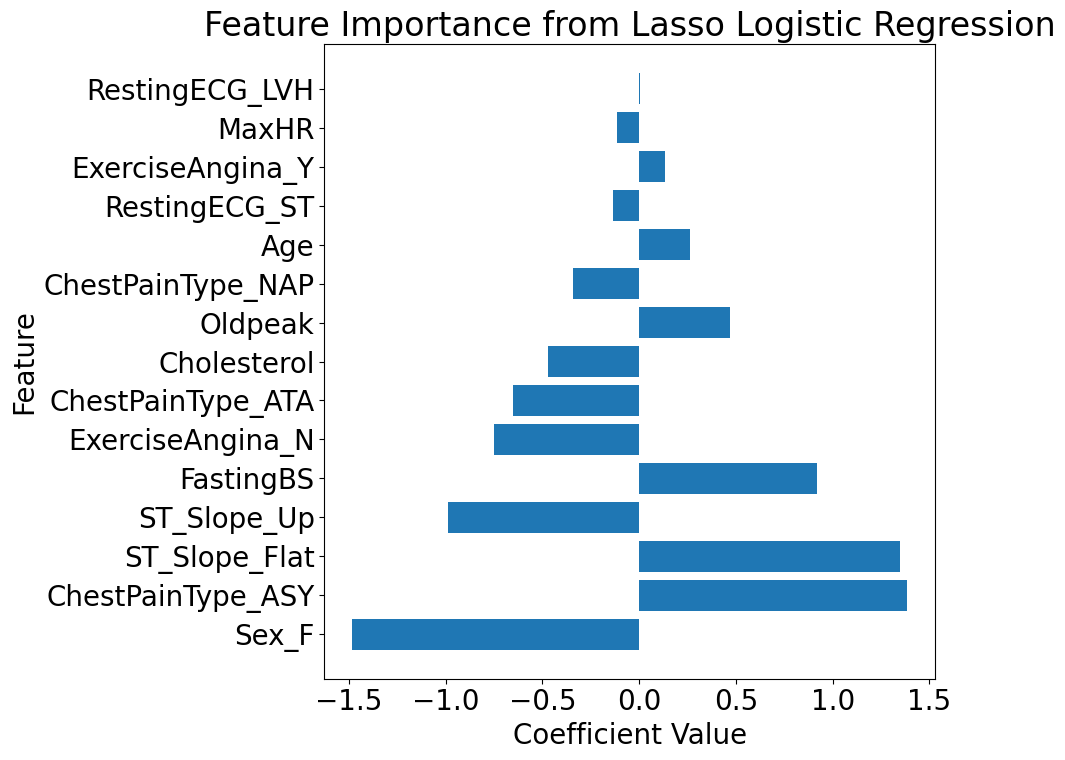

In [6]:
plt.rcParams.update({'font.size': 20}) 

# Get feature coefficients
coefficients = final_model.coef_[0]  # For binary classification

# Create DataFrame for better visualization 
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

# Sort by absolute coefficient value
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

# Plot non-zero coefficients (L1 regularization creates sparsity)
non_zero_coef = coef_df[coef_df['Coefficient'] != 0]
print(f"Number of features selected by Lasso: {len(non_zero_coef)} out of {len(coef_df)}")

# Plot
plt.figure(figsize=(10, 8))
plt.barh(non_zero_coef['Feature'], non_zero_coef['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance from Lasso Logistic Regression')
plt.tight_layout()
plt.show()